* Use the face detection model MobileNet SSD v2 (face) - no labels required

In [47]:
import numpy as np
import os
from PIL import Image, ImageDraw
from helpers import draw_box

import tflite_runtime.interpreter as tflite

In [48]:
all_models_dir = '/home/pi/github/edgetpu/test_data/'

In [49]:
all_models = os.listdir(all_models_dir)

In [50]:
for filename in all_models:
    if 'ssd_v2' in filename:
        print(filename)

mobilenet_ssd_v2_face_quant_postprocess.tflite
mobilenet_ssd_v2_face_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess_edgetpu.tflite
mobilenet_ssd_v2_coco_quant_postprocess.tflite


In [51]:
image_file = 'images/' + 'face.jpg'
# image = all_models_dir + 'parrot.jpg'
image_file

'images/face.jpg'

In [52]:
model_file = all_models_dir + 'mobilenet_ssd_v2_face_quant_postprocess.tflite'
model_file

'/home/pi/github/edgetpu/test_data/mobilenet_ssd_v2_face_quant_postprocess.tflite'

In [53]:
interpreter = tflite.Interpreter(model_path=model_file)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [54]:
# NxHxWxC, H:1, W:2. Note this is not maintaining aspect ratio
height = input_details[0]['shape'][1]
print(height)
width = input_details[0]['shape'][2]
print(width)
image = Image.open(image_file).resize((width, height))

320
320


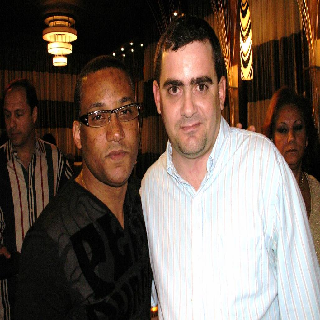

In [55]:
img

In [56]:
# add N dim
input_data = np.expand_dims(img, axis=0)

In [57]:
input_data.shape

(1, 320, 320, 3)

In [58]:
if floating_model:
    input_data = (np.float32(input_data) - input_mean) / input_std

In [59]:
%%time
interpreter.set_tensor(input_details[0]['index'], input_data)

interpreter.invoke()

boxes = interpreter.get_tensor(output_details[0]['index'])[0] # Bounding box coordinates of detected objects
classes = interpreter.get_tensor(output_details[1]['index'])[0] # Class index of detected objects
scores = interpreter.get_tensor(output_details[2]['index'])[0] # Confidence of detected objects

CPU times: user 322 ms, sys: 9.11 ms, total: 331 ms
Wall time: 356 ms


In [61]:

min_conf_threshold = 0.3
draw = ImageDraw.Draw(image)
img_height, img_width = image.size

for i in range(len(scores)):
    if ((scores[i] > min_conf_threshold) and (scores[i] <= 1.0)):

        y_min = int(max(1,(boxes[i][0] * img_height)))/img_height
        x_min = int(max(1,(boxes[i][1] * img_width)))/img_width
        y_max = int(min(img_height,(boxes[i][2] * img_height)))/img_height
        x_max = int(min(img_width,(boxes[i][3] * img_width)))/img_width
        box = (y_min, x_min, y_max, x_max)
        print(box)
        draw_box(draw, box, img_width, img_height)



(0.06875, 0.409375, 0.496875, 0.775)
(0.15, 0.134375, 0.6125, 0.53125)
(0.3, 0.809375, 0.525, 0.996875)
(0.259375, 0.003125, 0.45625, 0.153125)


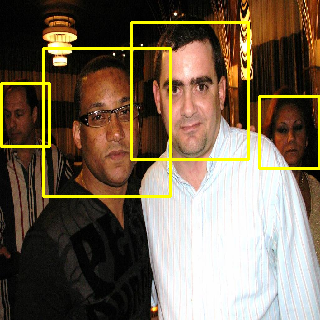

In [62]:
display(image)